> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Training a model

In [1]:
import os

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

c:\Users\CalvinPuah-Pernix\anaconda3\envs\rastervision\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To keep things simple, we use one scene for training and one for validation. In a real workflow, we would normally use many more scenes.

In [3]:
train_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
train_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [4]:
val_image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif'
val_label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson'

In [5]:
import albumentations as A

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset,
    SemanticSegmentationSlidingWindowGeoDataset,
    SemanticSegmentationVisualizer)

viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

In [6]:
class SemanticSegmentationRandomWindowGeoDatasetCustom(SemanticSegmentationRandomWindowGeoDataset):
	def __getitem__(self, key):
		x, y = super().__getitem__(key)
		y = y.long()
		return x, y

class SemanticSegmentationSlidingWindowGeoDatasetCustom(SemanticSegmentationSlidingWindowGeoDataset):
	def __getitem__(self, key):
		x, y = super().__getitem__(key)
		y = y.long()
		return x, y

In [7]:
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RGBShift(),
        A.ToGray(),
        A.ToSepia(),
        A.RandomBrightness(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=5)
])

#train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
train_ds = SemanticSegmentationRandomWindowGeoDatasetCustom.from_uris(
    class_config=class_config,
    image_uri=train_image_uri,
    label_vector_uri=train_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size_lims=(150, 200),
    out_size=256,
    max_windows=400,
    transform=data_augmentation_transform)

len(train_ds)

2024-03-08 15:05:54:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif.


2024-03-08 15:05:55:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.
2024-03-08 15:05:55:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in s3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson and assuming EPSG:4326 instead.


400

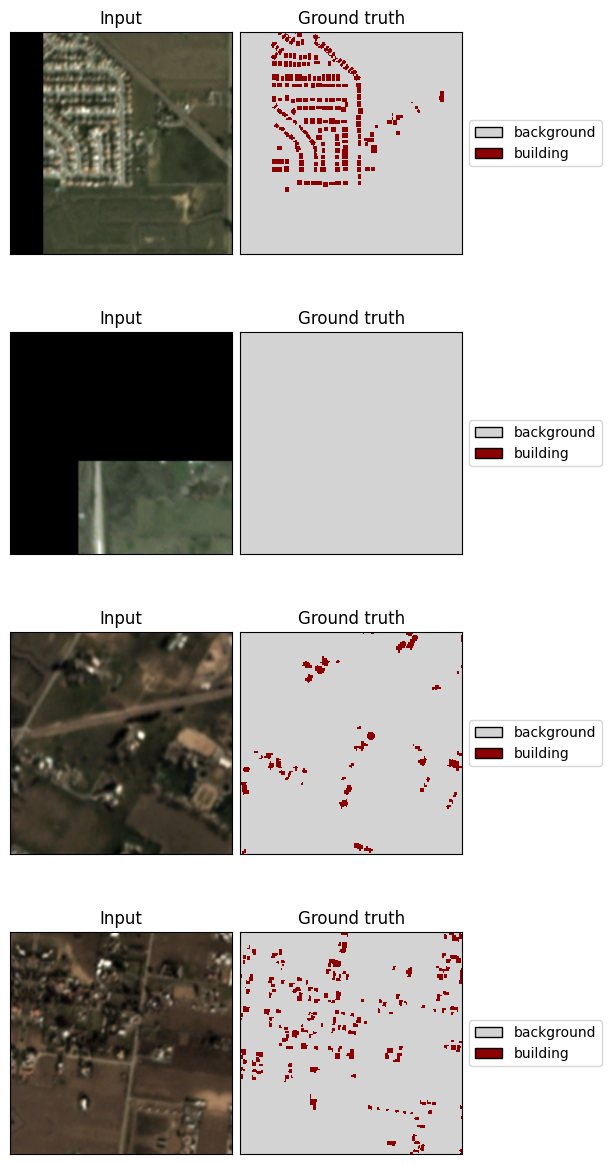

In [8]:
x, y = viz.get_batch(train_ds, 4)
viz.plot_batch(x, y, show=True)

In [9]:
#val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
val_ds = SemanticSegmentationSlidingWindowGeoDatasetCustom.from_uris(
    class_config=class_config,
    image_uri=val_image_uri,
    label_vector_uri=val_label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    size=200,
    stride=100,
    transform=A.Resize(256, 256))
len(val_ds)

2024-03-08 15:05:57:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/images/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13.tif.
2024-03-08 15:05:57:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\CALVIN~1\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson.
2024-03-08 15:05:57:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in s3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0357E-1223N_1429_3296_13/labels/global_monthly_2018_01_mosaic_L15-0357E-1223N_1429_3296_13_Buildings.geojson and assuming EPSG:4326 instead.


100

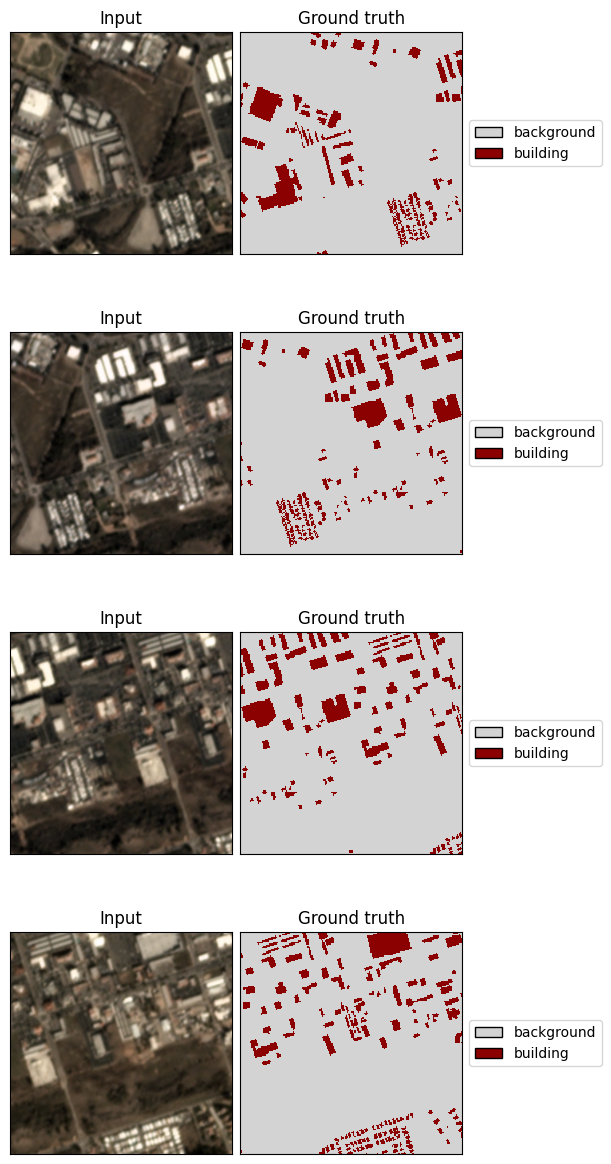

In [10]:
x, y = viz.get_batch(val_ds, 4)
viz.plot_batch(x, y, show=True)

## Define model

Use a [light-weight panoptic FPN model](https://github.com/AdeelH/pytorch-fpn) with a ResNet-18 backbone.

In [11]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(256, 256),
    pretrained=True)

Using cache found in C:\Users\CalvinPuah-Pernix/.cache\torch\hub\AdeelH_pytorch-fpn_0.3


## Configure the training

In [12]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0, # increase to use multi-processing
)

In [13]:
from rastervision.pytorch_learner import SolverConfig

solver_cfg = SolverConfig(
    batch_sz=8,
    lr=3e-2,
    class_loss_weights=[1., 10.]
)

In [14]:
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

In [15]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
)

2024-03-08 15:06:54:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./train-demo/last-model.pth


In [16]:
learner.log_data_stats()

2024-03-08 15:06:58:rastervision.pytorch_learner.learner: INFO - train_ds: 400 items
2024-03-08 15:06:58:rastervision.pytorch_learner.learner: INFO - valid_ds: 100 items


## Run `Tensorboard` for monitoring

In [17]:
%load_ext tensorboard

This will start an instance of tensorboard and embed it in the output of the cell:

In [18]:
%tensorboard --bind_all --logdir "./train-demo/tb-logs" --reload_interval 10 

Reusing TensorBoard on port 6006 (pid 9020), started 3 days, 22:23:04 ago. (Use '!kill 9020' to kill it.)

![A screenshot of the Tensorboard dashboard.](../../img/tensorboard.png "A screenshot of the Tensorboard dashboard.")


In [19]:
learner.train(epochs=3)

2024-03-05 09:42:16:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]
2024-03-05 09:45:03:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.35306206345558167,
 'train_time': '0:02:27.721204',
 'val_loss': 0.45281022787094116,
 'avg_precision': 0.9298018217086792,
 'avg_recall': 0.8454455733299255,
 'avg_f1': 0.8856194615364075,
 'background_precision': 0.9744500517845154,
 'background_recall': 0.8581871390342712,
 'background_f1': 0.9126307368278503,
 'building_precision': 0.2227754294872284,
 'building_recall': 0.6436768174171448,
 'building_f1': 0.33099430799484253,
 'valid_time': '0:00:19.247032'}
2024-03-05 09:45:03:rastervision.pytorch_learner.learner: INFO - epoch: 1
Validating: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]
2024-03-05 09:47:54:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 1,
 'train_loss': 0.2663315534591675,
 'train_time': '0:02:31.274933',
 'val

## Train some more

In [20]:
learner.train(epochs=1)

2024-03-05 09:50:57:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 3
2024-03-05 09:50:57:rastervision.pytorch_learner.learner: INFO - epoch: 3
Validating: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]
2024-03-05 09:53:52:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 3,
 'train_loss': 0.24339477717876434,
 'train_time': '0:02:35.456706',
 'val_loss': 0.6607006788253784,
 'avg_precision': 0.9237952828407288,
 'avg_recall': 0.9034672379493713,
 'avg_f1': 0.9135181307792664,
 'background_precision': 0.9636273384094238,
 'background_recall': 0.9325717091560364,
 'background_f1': 0.9478452205657959,
 'building_precision': 0.2930352985858917,
 'building_recall': 0.44258400797843933,
 'building_f1': 0.3526082932949066,
 'valid_time': '0:00:19.898213'}


2024-03-05 09:54:01:rastervision.pytorch_learner.learner: INFO - Making and plotting sample predictions on the valid set...


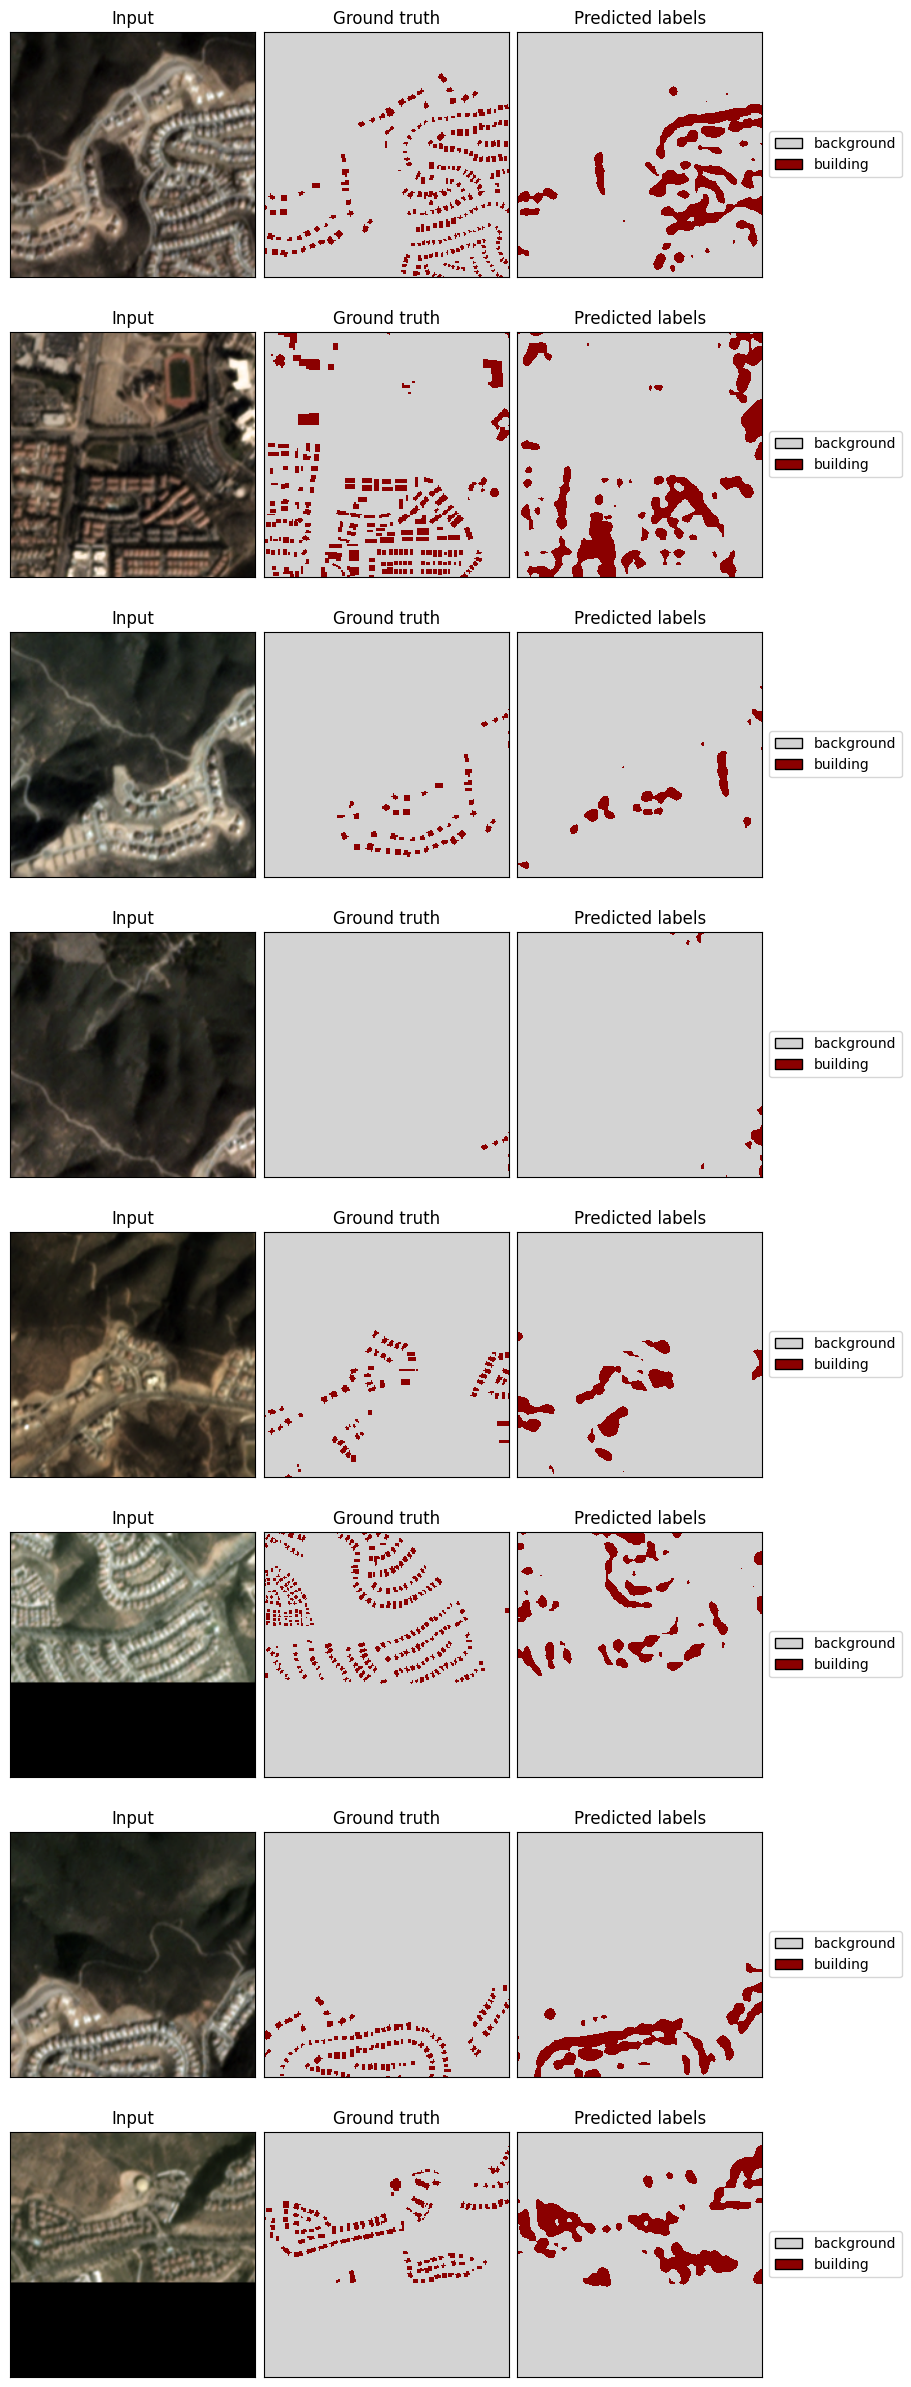

2024-03-05 09:54:04:rastervision.pytorch_learner.learner: INFO - Sample predictions written to ./train-demo/valid_preds.png.


<Figure size 640x480 with 0 Axes>

In [21]:
learner.plot_predictions(split='valid', show=True)

Note the warning about `ModelConfig`. This is relevant when loading from from the bundle as we will see [below](#Using-model-bundles).

In [27]:
learner.save_model_bundle()

2024-03-05 09:58:24:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-03-05 09:58:24:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2024-03-05 09:58:24:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2024-03-05 09:58:26:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./train-demo/model-bundle.zip.


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Examine learner output

The trained model weights are saved at `./train-demo/last-model.pth` as well as inside the model-bundle.

In [23]:
!tree "./train-demo/"

Folder PATH listing for volume Windows
Volume serial number is 8E4A-33CB
C:\USERS\CALVINPUAH-PERNIX\RASTER-VISION\DOCS\USAGE\TUTORIALS\TRAIN-DEMO
+---tb-logs


## Using model-bundles

We can use the model-bundle to re-construct our `Learner` and then use it to make predictions.

In [24]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
)

2024-03-05 09:54:30:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2024-03-05 09:54:30:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\CALVIN~1\AppData\Local\Temp\tmpfoeaz_56\model-bundle
2024-03-05 09:54:31:rastervision.pytorch_learner.learner: INFO - Loading model weights from: C:\Users\CALVIN~1\AppData\Local\Temp\tmpfoeaz_56\model-bundle\model.pth


For next steps, see the ["Prediction and Evaluation" tutorial](./pred_and_eval_ss.ipynb).

We can also re-construct the `Learner` in order to continue training, perhaps on a different dataset. To do this, we pass in `train_ds` and `val_ds` and set `training=True`

In [25]:
from rastervision.pytorch_learner import SemanticSegmentationLearner

learner = SemanticSegmentationLearner.from_model_bundle(
    model_bundle_uri='./train-demo/model-bundle.zip',
    output_dir='./train-demo/',
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2024-03-05 09:54:38:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./train-demo/model-bundle.zip.
2024-03-05 09:54:38:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\CALVIN~1\AppData\Local\Temp\tmp41z890h3\model-bundle
2024-03-05 09:54:39:rastervision.pytorch_learner.learner: INFO - Loading model weights from: C:\Users\CALVIN~1\AppData\Local\Temp\tmp41z890h3\model-bundle\model.pth
2024-03-05 09:54:39:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ./train-demo/last-model.pth


Continue training:

In [26]:
learner.train(epochs=1)

2024-03-05 09:54:43:rastervision.pytorch_learner.learner: INFO - Resuming training from epoch 4
2024-03-05 09:54:43:rastervision.pytorch_learner.learner: INFO - epoch: 4
Validating: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]
2024-03-05 09:57:42:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 4,
 'train_loss': 0.30910754203796387,
 'train_time': '0:02:38.549002',
 'val_loss': 0.5338159203529358,
 'avg_precision': 0.9203276634216309,
 'avg_recall': 0.9213706851005554,
 'avg_f1': 0.9208488464355469,
 'background_precision': 0.957389771938324,
 'background_recall': 0.9590912461280823,
 'background_f1': 0.958239734172821,
 'building_precision': 0.3334311246871948,
 'building_recall': 0.32404765486717224,
 'building_f1': 0.3286724090576172,
 'valid_time': '0:00:20.624981'}
